<a href="https://colab.research.google.com/github/s20488/PJN/blob/main/Anastasiia_Ponkratova_Transformer_from_scratch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Transformer from Scratch

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

## Part 1: Self-Attention Implementation

#### Intuitive Understanding
Think of attention as a way to focus on relevant parts of input data, similar to how humans focus on specific parts of an image. The mechanism works like a sophisticated lookup system:
- **Query (Q)**: What you're looking for
- **Key (K)**: What you're matching against
- **Value (V)**: The actual information you want to retrieve


---

### Mathematical Formulation
The attention formula is:

$$\text{Attention}(Q, K, V) = \text{softmax}\left(\frac{QK^T}{\sqrt{d_k}}\right)V$$

Where:
- Q, K, V are matrices representing queries, keys, and values
- $d_k$ is the dimension of the key vectors
- $\frac{1}{\sqrt{d_k}}$ is the scaling factor to prevent vanishing gradients
- Softmax normalizes the attention scores to sum to 1


---

### Implementation

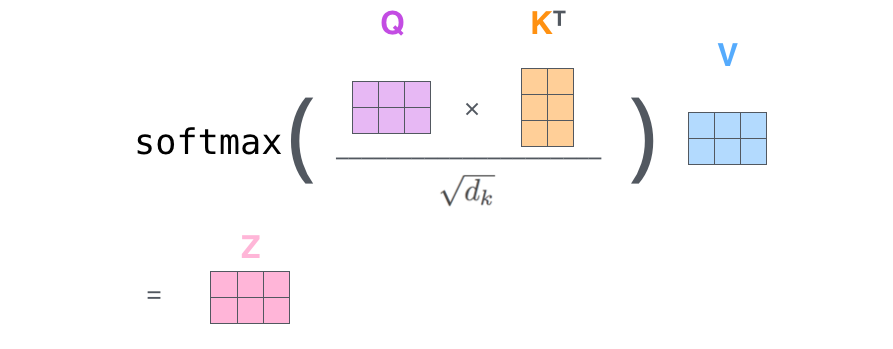

1. **Calculate Attention Scores**:
   -M ultiply query with key's transpose
   - Remember to transpose only the last two dimensions of key using `transpose(-2, -1)`
   - Calculate scaling factor: `sqrt(d_k)` where d_k is the size of key dimension
   - Divide scores by scaling factor

2. **Apply Mask** (if provided):
   - Check if mask exists
   - Use `masked_fill` operation to replace masked positions with a large negative number (hint: -1e9)
   - The mask should be broadcastable to the scores shape

3. **Calculate Attention Weights**:
   - Apply softmax along the last dimension using
   - This normalizes attention scores into probabilities

4. **Compute Final Output**:
   - Multiply attention weights with values
   - Return both the output and attention weights for visualization/analysis

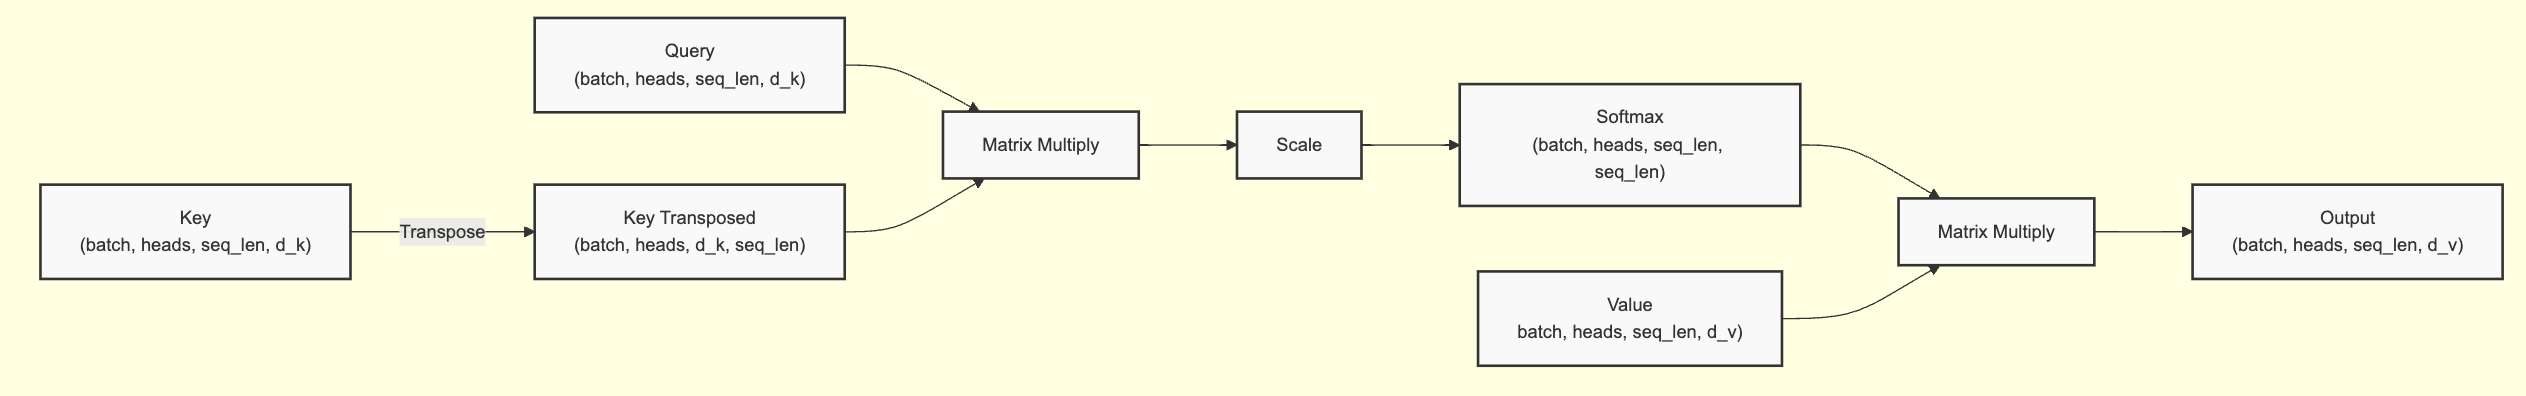

In [ ]:
def scaled_dot_product_attention(query, key, value, mask=None):
    """
    Params:
        query: shape (batch_size, num_heads, seq_len, d_k)
        key: shape (batch_size, num_heads, seq_len, d_k)
        value: shape (batch_size, num_heads, seq_len, d_v)
        mask: shape (batch_size, 1, seq_len, seq_len)
    """
    d_k = query.size(-1)

    # Compute attention scores
    # Matrix multiplication of Q and K^T
    # Scale by sqrt(d_k)
    scores = torch.matmul(query, key.transpose(-2, -1)) / torch.sqrt(torch.tensor(d_k, dtype=query.dtype))

    # Apply mask if provided
    if mask is not None:
        scores = scores.masked_fill(mask == 0, float('-inf'))

    # Apply softmax to get attention weights
    attention_weights = F.softmax(scores, dim=-1)
    # Compute output - multiply values by attention scores
    output = torch.matmul(attention_weights, value)

    return output, attention_weights

### Tests

In [ ]:
def test_scaled_dot_product_attention():
    """Test the scaled dot-product attention mechanism"""
    # Test case 1: Basic dimension check
    batch_size, num_heads, seq_len, d_k = 2, 4, 6, 8
    query = torch.randn(batch_size, num_heads, seq_len, d_k)
    key = torch.randn(batch_size, num_heads, seq_len, d_k)
    value = torch.randn(batch_size, num_heads, seq_len, d_k)

    output, attention = scaled_dot_product_attention(query, key, value)

    # Check output dimensions
    assert output.shape == (batch_size, num_heads, seq_len, d_k), \
        f"Expected output shape {(batch_size, num_heads, seq_len, d_k)}, got {output.shape}"

    # Check attention matrix dimensions
    assert attention.shape == (batch_size, num_heads, seq_len, seq_len), \
        f"Expected attention shape {(batch_size, num_heads, seq_len, seq_len)}, got {attention.shape}"

    # Test case 2: Check masking
    mask = torch.ones(batch_size, 1, seq_len, seq_len)
    mask[:, :, 0, :] = 0  # mask first position
    output_masked, attention_masked = scaled_dot_product_attention(query, key, value, mask)

In [ ]:
test_scaled_dot_product_attention()

## Part 2: Multi-Head Attention


### Intuitive Understanding
Multi-head attention is like having multiple "experts" looking at the same data from different perspectives. Each head can focus on different aspects of the input, making the model more robust.

---

### Mathematical Formulation
The multi-head attention mechanism:

$$\text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1, ..., \text{head}_h)W^O$$

Where each head is:

$$\text{head}_i = \text{Attention}(QW^Q_i, KW^K_i, VW^V_i)$$

---



### Implementation
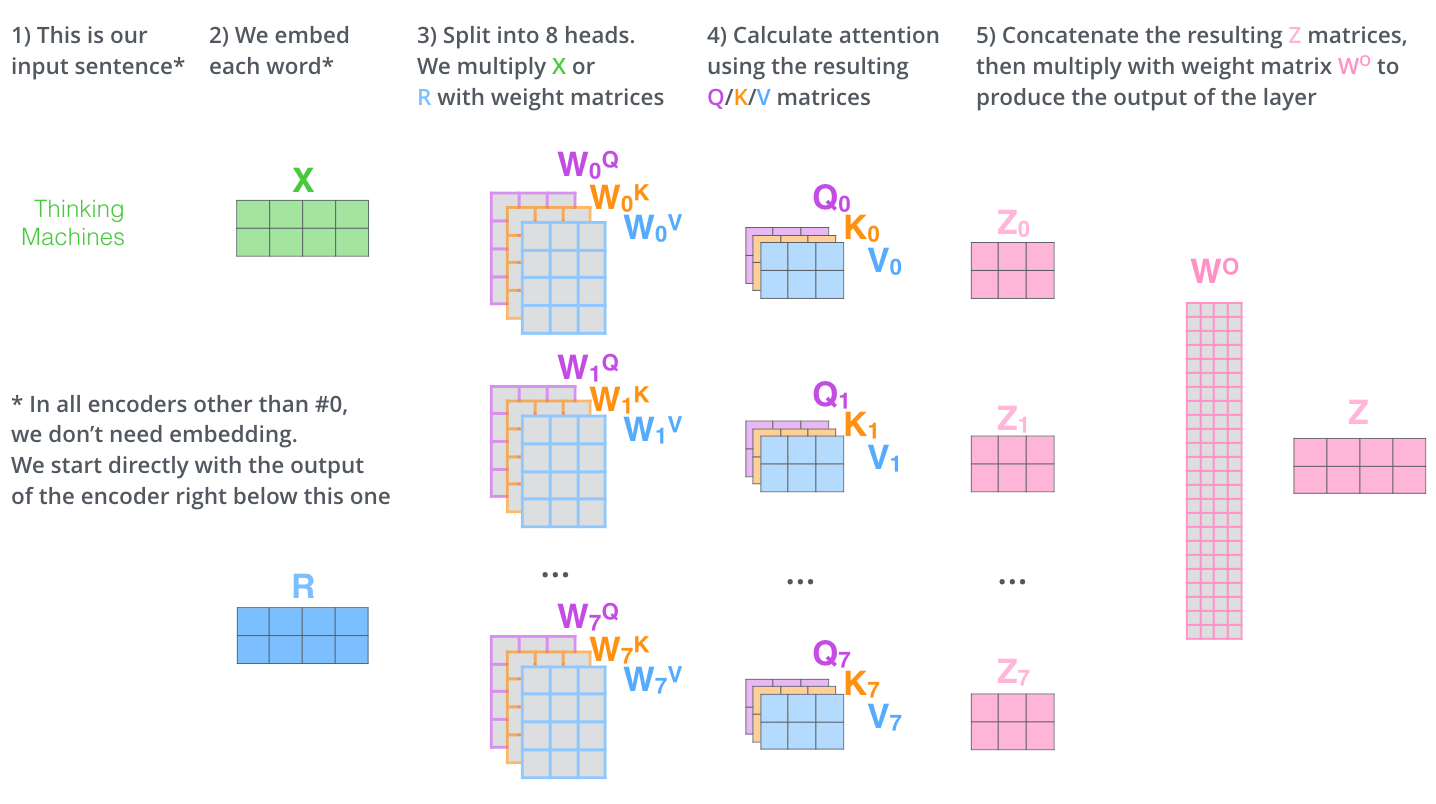
#### Inicjalization
1. **Setup Parameters**:
   - Store d_model and num_heads
   - Calculate d_k (d_model divided by num_heads)
   - Verify d_model is divisible by num_heads

2. **Create Projection Layers**:
   - Initialize four linear layers (no bias necessary):
     - Query projection (d_model → d_model)
     - Key projection (d_model → d_model)
     - Value projection (d_model → d_model)
     - Output projection (d_model → d_model)

#### Implement split_heads Method:
1. **Reshape input tensor to separate heads**:
   - Start with (batch_size, seq_len, d_model)
   - Reshape to (batch_size, seq_len, num_heads, d_k)
   - Transpose to (batch_size, num_heads, seq_len, d_k)
   Hint: Use `view` and `transpose` operations

#### Forward Method Steps:
1. **Project and Split Heads**:
   - Apply linear projections to inputs
   - Split each projection into multiple heads
   - Use your split_heads method

2. **Apply Attention**:
   - Use your scaled_dot_product_attention function
   - Pass the mask if provided

3. **Combine Heads**:
   - Transpose heads back to original position
   - Reshape to combine all heads
   - Apply output projection
   Hint: Use `contiguous()` before reshaping


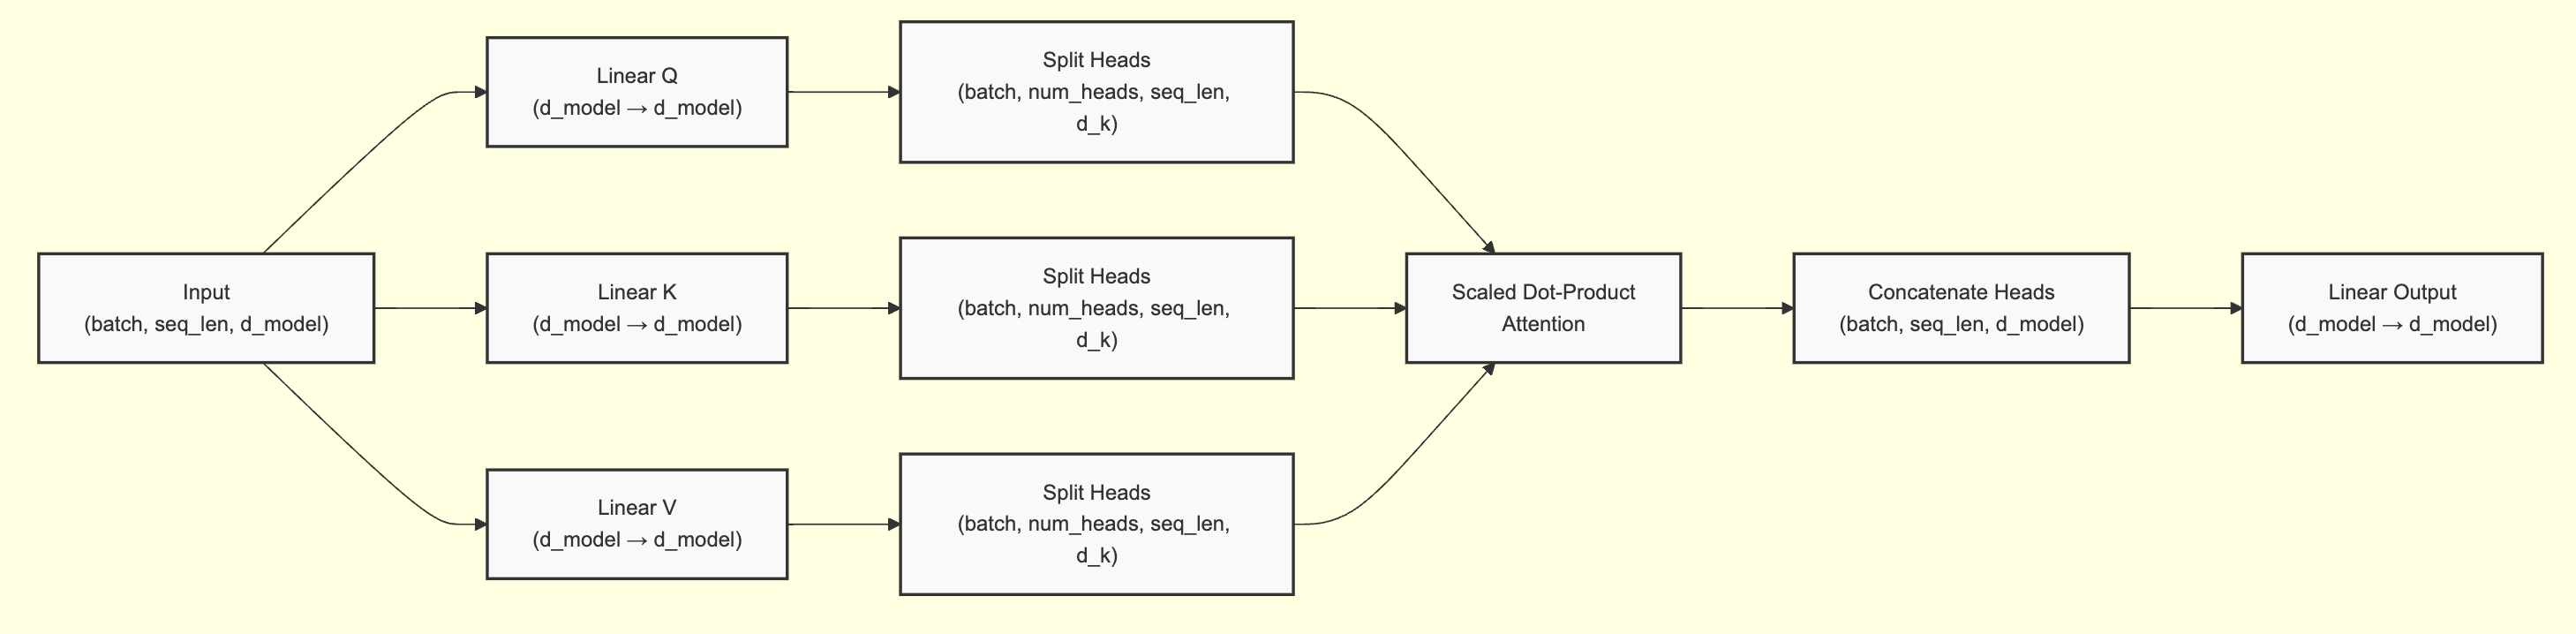

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super().__init__()
        assert d_model % num_heads == 0

        # Initialize Parameters
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

    def split_heads(self, x):
       batch_size = x.size(0)
       # Reshape to separate heads
       x = x.view(batch_size, -1, self.num_heads, self.d_k)
       # Transpose to get shape (batch, heads, seq_len, d_k)
       return x.transpose(1, 2)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        # Project and split heads
        query = self.split_heads(self.W_q(query))
        key = self.split_heads(self.W_k(key))
        value = self.split_heads(self.W_v(value))

        output, attention = scaled_dot_product_attention(query, key, value, mask)

        output = output.transpose(1, 2).contiguous()
        output = output.view(batch_size, -1, self.d_model)
        output = self.W_o(output)

        return output, attention

In [ ]:
def test_multi_head_attention():
    """Test the multi-head attention module"""
    batch_size, seq_len = 2, 6
    d_model, num_heads = 64, 8

    mha = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    x = torch.randn(batch_size, seq_len, d_model)

    # Test forward pass
    output, attention = mha(x, x, x)

    # Check output dimensions
    assert output.shape == (batch_size, seq_len, d_model), \
        f"Expected output shape {(batch_size, seq_len, d_model)}, got {output.shape}"

    # Test with mask
    mask = torch.ones(batch_size, 1, seq_len, seq_len)
    output_masked, attention_masked = mha(x, x, x, mask)
    assert output_masked.shape == (batch_size, seq_len, d_model), \
        "Masked output shape doesn't match expected shape"

In [ ]:
test_multi_head_attention()

## Part 3: Position-wise Feed-Forward Network


### Intuitive Understanding
The Position-wise Feed-Forward Network (FFN) processes each position in the sequence independently, allowing the model to transform the attention output further. Think of it as giving each position its own small neural network to capture more complex patterns.


---

#### Mathematical Formulation
The FFN applies two linear transformations with a ReLU activation in between:

$$ \text{FFN}(x) = \max(0, xW_1 + b_1)W_2 + b_2$$

Where:
- $W_1, W_2$ are weight matrices
- $b_1, b_2$ are bias vectors
- $\max(0, x)$ is the ReLU activation function

---

### Implementation

1. **Initialize Components**:
   - Create first linear layer (d_model → d_ff)
   - Create second linear layer (d_ff → d_model)
   - Initialize dropout with specified rate

2. **Forward Pass**:
   - Apply first linear layer
   - Apply ReLU activation
   - Apply dropout
   - Apply second linear layer
   Hint: Order matters! Think about where dropout should be applied

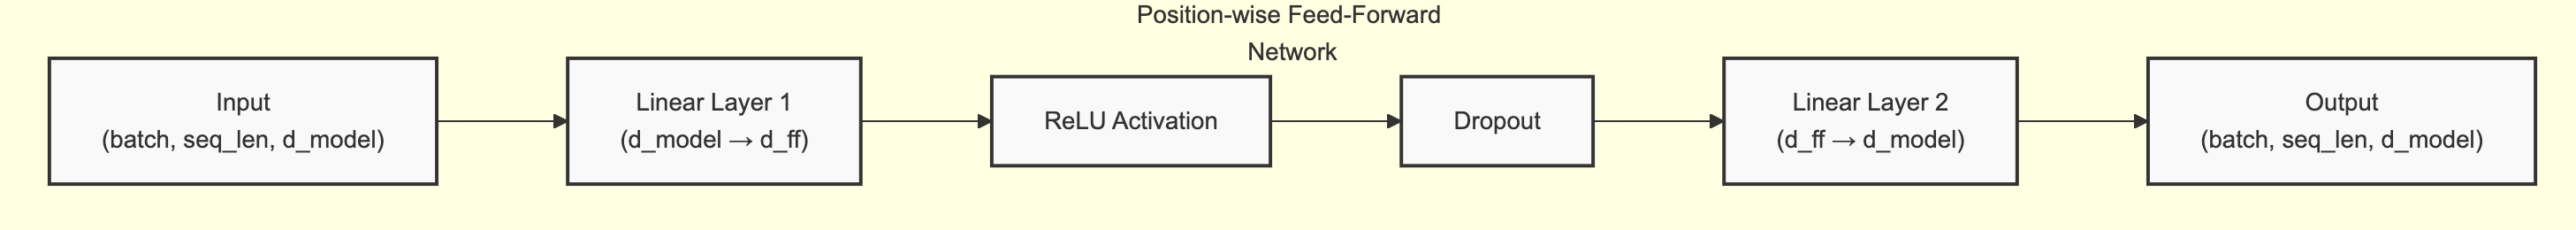

In [ ]:
class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff, dropout=0.1):
        super().__init__()
        # First linear transformation
        self.linear1 = nn.Linear(d_model, d_ff)
        # Second linear transformation
        self.linear2 = nn.Linear(d_ff, d_model)
        # Dropout for regularization
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
      # Apply first linear layer
      x = self.linear1(x)
      # Apply ReLU activation
      x = F.relu(x)
      # Apply dropout
      x = self.dropout(x)
      # Apply second linear layer
      x = self.linear2(x)
      return x

In [ ]:

def test_position_wise_feed_forward():
    """Test the position-wise feed-forward network"""
    batch_size, seq_len = 2, 6
    d_model, d_ff = 64, 256

    ff = PositionwiseFeedForward(d_model=d_model, d_ff=d_ff)
    x = torch.randn(batch_size, seq_len, d_model)

    output = ff(x)

    # Check output dimensions
    assert output.shape == x.shape, \
        f"Expected output shape {x.shape}, got {output.shape}"

    # Test different sequence lengths
    x_long = torch.randn(batch_size, seq_len * 2, d_model)
    output_long = ff(x_long)
    assert output_long.shape == x_long.shape, \
        "Feed-forward network should handle different sequence lengths"

In [ ]:
test_position_wise_feed_forward()

## Part 4: Positional Encoding


#### Intuitive Understanding
Since transformers process all tokens simultaneously (unlike RNNs), they need a way to know the position of each token in the sequence. Positional encoding adds this information using sinusoidal functions of different frequencies, creating a unique pattern for each position.


#### Mathematical Formulation
For position $pos$ and dimension $i$:

$$PE_{(pos,2i)} = \sin(pos/10000^{2i/d_{model}})$$
$$PE_{(pos,2i+1)} = \cos(pos/10000^{2i/d_{model}})$$

Where:
- $pos$ is the position in the sequence
- $i$ is the dimension
- $d_{model}$ is the embedding dimension

### Implementation

1. **Initialize Encoding Matrix**:
   - Create matrix of zeros (max_seq_length × d_model)
   - Generate position tensor (0 to max_seq_length)
   - Calculate division terms using exponential function
   Hint: Use `torch.arange` and `torch.exp`

2. **Calculate Encodings**:
   - Even indices: Apply sine function
   - Odd indices: Apply cosine function
   - Store as buffer using `register_buffer`

3. **Forward Method**:
   - Add positional encoding to input
   - Handle variable sequence lengths by slicing stored encoding


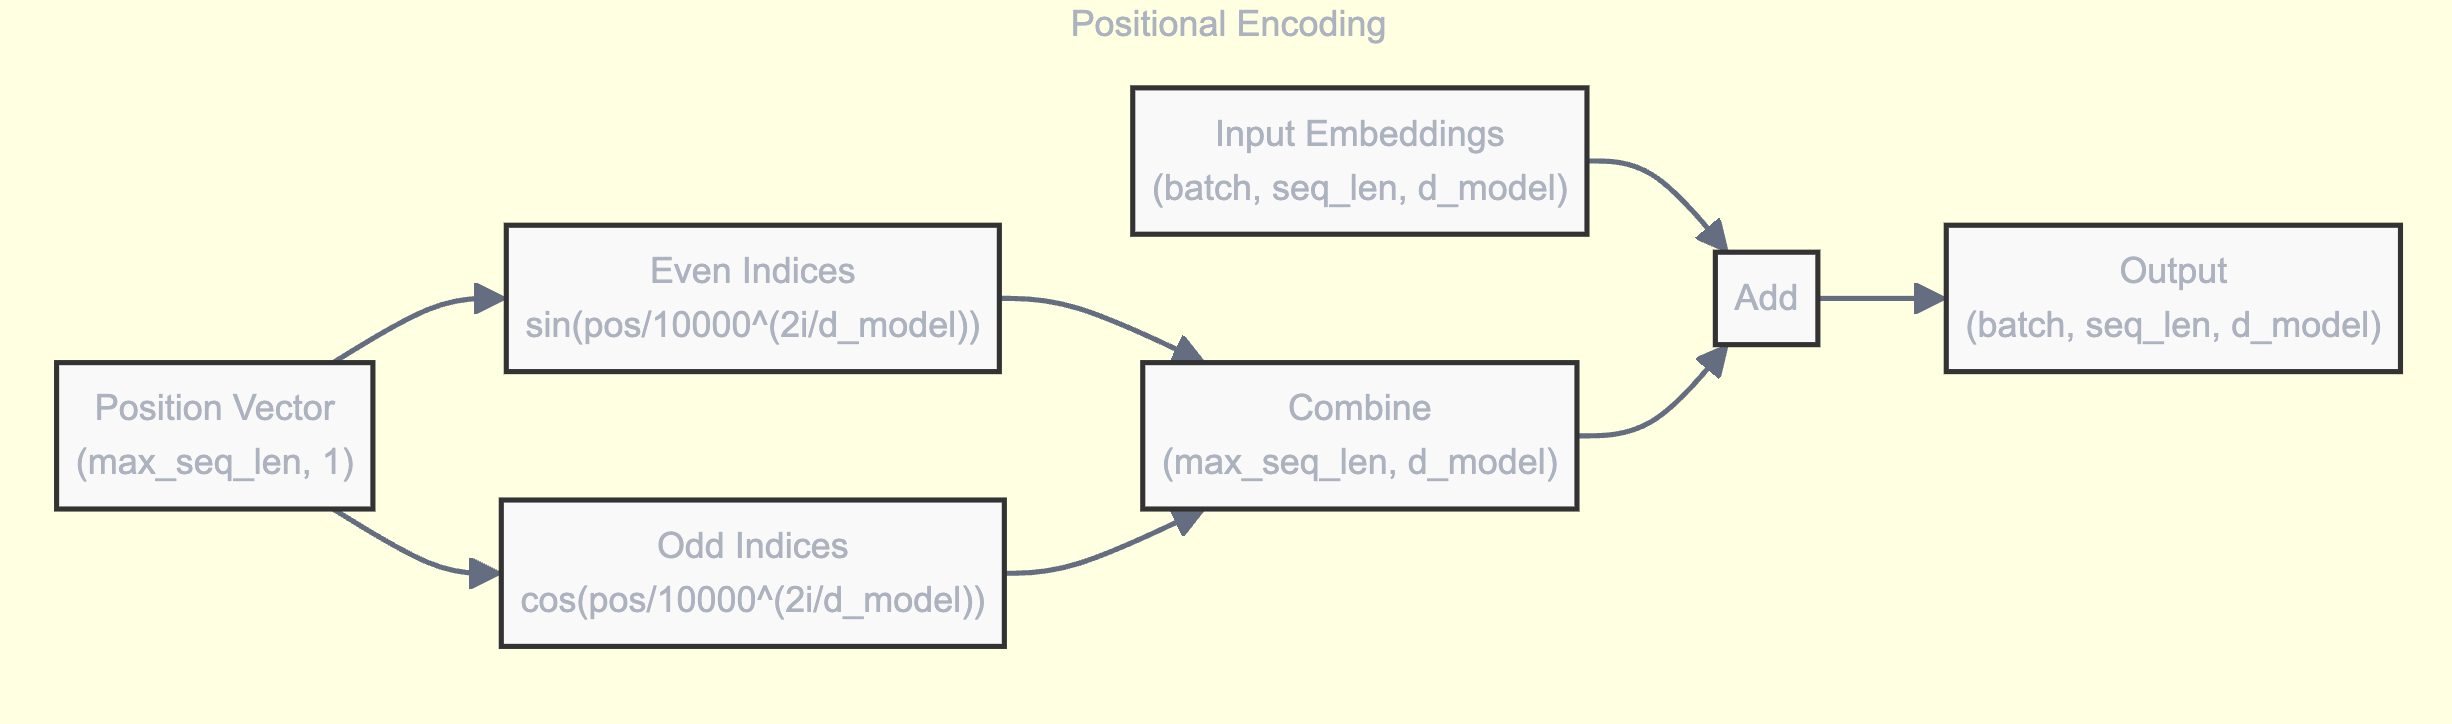

In [ ]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length=5000):
        super().__init__()


        pe = torch.zeros(max_seq_length, d_model)  # Create empty matrix for positional encodings
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)  # Generate position tensor (0 to max_seq_length)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() *
                           (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)  # Even indices: Apply sine function
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd indices: Apply cosine function

        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [ ]:
def test_positional_encoding():
    """Simplified test for positional encoding"""
    d_model = 64
    max_seq_length = 100

    # Create the positional encoding module
    pe = PositionalEncoding(d_model=d_model, max_seq_length=max_seq_length)

    # Test with a simple input
    batch_size, seq_len = 2, 10
    x = torch.randn(batch_size, seq_len, d_model)
    output = pe(x)

    # Basic shape tests
    assert output.shape == x.shape, \
        f"Expected shape {x.shape}, got {output.shape}"
    assert pe.pe.shape == (1, max_seq_length, d_model), \
        f"Expected PE shape (1, {max_seq_length}, {d_model}), got {pe.pe.shape}"

    # Test that PE values are within expected range
    assert torch.all(pe.pe >= -1) and torch.all(pe.pe <= 1), \
        "PE values should be between -1 and 1"

    # Test that different positions have different encodings
    pos0 = pe.pe[0, 0]
    pos1 = pe.pe[0, 1]
    assert not torch.allclose(pos0, pos1), \
        "Different positions should have different encodings"

In [ ]:
test_positional_encoding()

## Part 5: Transformer Encoder Layer Implementation Guide



### Intuitive Understanding
A transformer encoder layer combines all the previous components in a specific order with residual connections and layer normalization. Think of it as an assembly line where the input goes through attention, normalization, feed-forward processing, and final normalization.

---

### Mathematical Formulation
The transformer encoder layer follows this sequence:

1. $\text{AttentionOutput} = \text{LayerNorm}(x + \text{MultiHeadAttention}(x))$
2. $\text{Output} = \text{LayerNorm}(\text{AttentionOutput} + \text{FFN}(\text{AttentionOutput}))$

---

### Implementation

1. **Initialize Components**:
   - Multi-head attention layer
   - Position-wise feed-forward network
   - Two layer normalization modules
   - Dropout layer

2. **Forward Pass Implementation**:
   - Apply self-attention
     * Pass input as query, key, and value
     * Include mask if provided
   - Add & Norm (first residual connection)
     * Add attention output to input
     * Apply layer normalization
   - Feed-forward network
     * Pass normalized output through FFN
   - Add & Norm (second residual connection)
     * Add FFN output to previous output
     * Apply layer normalization

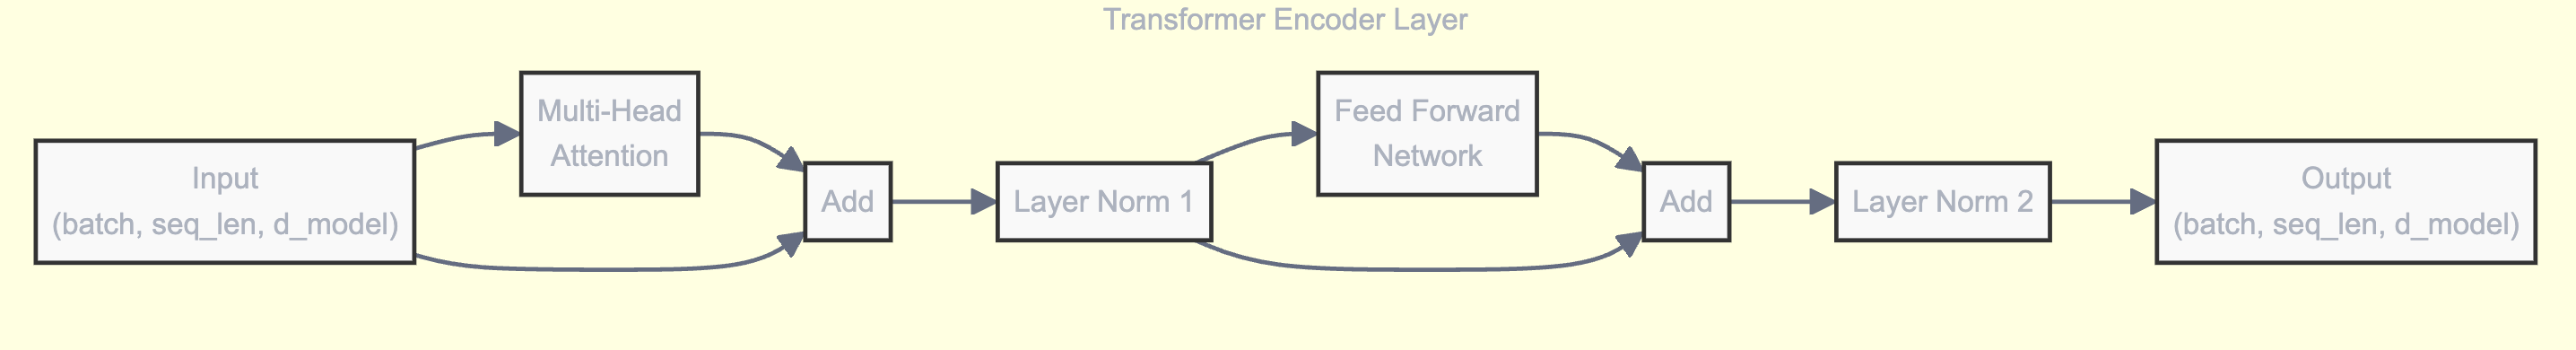

In [ ]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout=0.1):
        super().__init__()

        self.self_attention = nn.MultiheadAttention(embed_dim=d_model, num_heads=num_heads, dropout=dropout, batch_first=True)

        self.feed_forward = nn.Sequential(nn.Linear(d_model, d_ff), nn.ReLU(), nn.Linear(d_ff, d_model))

        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

        self.dropout = nn.Dropout(dropout)

        self.num_heads = num_heads

    def forward(self, x, mask=None):
        if mask is not None and mask.dim() == 4:
            mask = mask[:, 0, :, :]
            mask = mask.repeat(self.num_heads, 1, 1)

        # Self attention
        attn_output, _ = self.self_attention(x, x, x, attn_mask=mask)

        # Add and morm
        x = self.norm1(x + self.dropout(attn_output))

        # Feed forward
        ff_output = self.feed_forward(x)

        # Add and norm
        x = self.norm2(x + self.dropout(ff_output))

        return x

In [ ]:
def test_transformer_encoder_layer():
    """Test the transformer encoder layer"""
    batch_size, seq_len = 2, 6
    d_model, num_heads, d_ff = 64, 8, 256

    encoder_layer = TransformerEncoderLayer(
        d_model=d_model,
        num_heads=num_heads,
        d_ff=d_ff
    )
    x = torch.randn(batch_size, seq_len, d_model)

    # Test forward pass
    output = encoder_layer(x)
    assert output.shape == x.shape, \
        f"Expected output shape {x.shape}, got {output.shape}"

    # Test with mask
    mask = torch.ones(batch_size, 1, seq_len, seq_len)
    output_masked = encoder_layer(x, mask)
    assert output_masked.shape == x.shape, \
        "Masked output shape doesn't match expected shape"

In [ ]:
test_transformer_encoder_layer()

## Part 6: Complete Transformer Implementation


1. **Initialize Components**:
   - Embedding layer (vocab_size → d_model)
   - Positional encoding layer
   - Stack of transformer encoder layers
   - Output linear layer (d_model → vocab_size)
   - Dropout layer

2. **Forward Pass**:
   - Convert input indices to embeddings
   - Add positional encoding
   - Apply dropout to embeddings
   - Pass through each encoder layer
   - Project to vocabulary size


In [ ]:
class SimpleTransformer(nn.Module):
    def __init__(self, vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout=0.1):
        super().__init__()

        self.embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)

        self.encoder_layers = nn.ModuleList([
            TransformerEncoderLayer(d_model, num_heads, d_ff, dropout)
            for _ in range(num_layers)
        ])

        self.output_layer = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, mask=None):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.dropout(x)

        for encoder_layer in self.encoder_layers:
            x = encoder_layer(x, mask)

        output = self.output_layer(x)
        return output

In [ ]:
def test_simple_transformer():
    """Test the complete transformer model"""
    batch_size, seq_len = 2, 10
    vocab_size = 1000
    d_model = 64
    num_heads = 8
    num_layers = 2
    d_ff = 256
    max_seq_length = 100

    model = SimpleTransformer(
        vocab_size=vocab_size,
        d_model=d_model,
        num_heads=num_heads,
        num_layers=num_layers,
        d_ff=d_ff,
        max_seq_length=max_seq_length
    )

    # Test with integer input (token indices)
    x = torch.randint(0, vocab_size, (batch_size, seq_len))
    output = model(x)

    # Check output dimensions
    expected_shape = (batch_size, seq_len, vocab_size)
    assert output.shape == expected_shape, \
        f"Expected output shape {expected_shape}, got {output.shape}"

    # Test with different sequence lengths
    x_short = torch.randint(0, vocab_size, (batch_size, seq_len // 2))
    output_short = model(x_short)
    expected_shape_short = (batch_size, seq_len // 2, vocab_size)
    assert output_short.shape == expected_shape_short, \
        "Model should handle different sequence lengths"

In [ ]:
test_simple_transformer()

## Final Tests

In [ ]:
def create_simple_dataset(seq_length=10, num_samples=1000):
    # Create a simple dataset where the task is to predict the next number
    X = torch.randint(0, 10, (num_samples, seq_length))
    y = torch.roll(X, -1, dims=1)
    y[:, -1] = 0  # padding for last position
    return X, y

In [ ]:
def train_transformer():
    # Hyperparameters
    vocab_size = 10
    d_model = 64
    num_heads = 4
    num_layers = 2
    d_ff = 256
    max_seq_length = 10

    # Create model and data
    model = SimpleTransformer(vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length)
    X, y = create_simple_dataset()

    # Training parameters
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())

    # Training loop
    for epoch in range(20):
        model.train()
        optimizer.zero_grad()

        outputs = model(X)
        loss = criterion(outputs.view(-1, vocab_size), y.view(-1))

        loss.backward()
        optimizer.step()

        if epoch % 2 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.4f}")

In [ ]:
train_transformer()

Epoch 0, Loss: 2.4249
Epoch 2, Loss: 2.2821
Epoch 4, Loss: 2.2382
Epoch 6, Loss: 2.1971
Epoch 8, Loss: 2.1563
Epoch 10, Loss: 2.1207
Epoch 12, Loss: 2.0860
Epoch 14, Loss: 2.0440
Epoch 16, Loss: 2.0065
Epoch 18, Loss: 1.9705


## Additional Resources and References

1. ["Attention Is All You Need"](https://arxiv.org/abs/1706.03762) - Original Transformer paper
2. [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html) - Detailed implementation guide
3. [Transformer Architecture: The Positional Encoding](https://kazemnejad.com/blog/transformer_architecture_positional_encoding/) - Deep dive into positional encoding
4. [PyTorch Documentation](https://pytorch.org/docs/stable/index.html) - Official PyTorch documentation
